In [1]:
import crcmod
import struct
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


# Flip a bit in a messsage
def flip_bit(msg, idx):
    bit_offset = idx % 8
    byte_offset = idx / 8
    mask = 0x1 << (7-bit_offset)
    return msg[:byte_offset] + chr(ord(msg[byte_offset]) ^ mask) + msg[(byte_offset+1):]

def xor_strings(s1,s2):
    xored_bytes = [ord(a) ^ ord(b) for a,b in zip(s1,s2)]
    return str(bytearray(xored_bytes))

def bin_str(s, sep=""):
    return sep.join(format(ord(c), '08b') for c in s)

def bin_short(short_val):
    return bin_str(struct.pack('>H', short_val))
    


In [2]:
# 1f014829080a1d1802ad2800002bdfff83c5 xor 
# 1f014829100a1d1802ad2800002bdfff014b = 
# 00000000180000000000000000000000828e (B1 & C1)

# 1f014829080a1d1802ad2800002bdfff83c5 xor
# 1f0148291c0a1d1802ad2800002bdfff020a = 
# 0000000014000000000000000000000081cf (B2 & C2)

# 1f02d5af180a1d1801d9180000102fff020a xor
# 1f02d5af140a1d1801d9180000102fff014b = 
# 000000000c00000000000000000000000341

# C2 = 0341
# B1 xor B2 = 000000000c0000000000000000000000 0341
diff1 = xor_strings("1f02d5af180a1d1801d9180000102fff020a".decode('hex'), "1f02d5af140a1d1801d9180000102fff014b".decode('hex'))
diff1.encode('hex')

'000000000c00000000000000000000000341'

In [3]:
# look at message differences of a standard crc16

poly = 0x104c1
crc = crcmod.mkCrcFun(poly, initCrc=0, xorOut=0x0, rev=False)

def view_diff(msg, bit_to_flip):
    m1 = msg.decode('hex')
    m2 = flip_bit(m1,bit_to_flip)

    diff = xor_strings(m1,m2)

    print "m1   %s, crc = %s" % (bin_str(m1), bin_short(crc(m1)))
    print "m2   %s, crc = %s" % (bin_str(m2), bin_short(crc(m2)))
    print "diff %s, crc = %s" % (bin_str(diff), bin_short(crc(diff)))
    crc_diff = crc(m1) ^ crc(m2)
    print "                                xored crcs = %s" % bin_short(crc_diff)
    return crc_diff

crc_diff1 = view_diff("deadbeef", 4)
print "=" * 80
crc_diff2 = view_diff("deadbeef", 5)

print "repoly = %s" % bin_short(((crc_diff2 << 1) ^ crc_diff1) & 0xffff)
print "poly   = %s" % bin_short(poly & 0xffff)


m1   11011110101011011011111011101111, crc = 0001010001011101
m2   11010110101011011011111011101111, crc = 0101100111111110
diff 00001000000000000000000000000000, crc = 0100110110100011
                                xored crcs = 0100110110100011
m1   11011110101011011011111011101111, crc = 0001010001011101
m2   11011010101011011011111011101111, crc = 1011000011101100
diff 00000100000000000000000000000000, crc = 1010010010110001
                                xored crcs = 1010010010110001
repoly = 0000010011000001
poly   = 0000010011000001


In [4]:
re_poly = (0b1100010110110010 << 1) ^ 0b1000110100100101
hex(re_poly)

'0x10641'

In [25]:
# Messages of length 10
single_bit_crcs10 = {
    30: 0b1000001010011011,
    31: 0b1000000101010001,
    34: 0b0000001110010010,
    35: 0b1000001100101000,
    36: 0b0000001100001110,
    37: 0b1000000100001011,
}

# Messages of length 3
single_bit_crcs3 = {
    30:  0b1000000100011111,
    31:  0b0000001000111100,
    34:  0b1000001011011100,
    35:  0b0000000111010111,
    36:  0b1000001101011001,
    37:  0b1000000000011000,
    38:  0b1000001010001110,
    116: 0b0000000000101010,
    117: 0b0000000011011010,
}

crc(30) = 1000000100011111
crc(31) = 0000001000111100
xform   = 1000010101100111


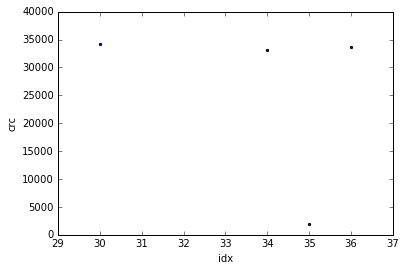

In [52]:
def crc_for(n):
    crc = single_bit_crcs3[n]
    
    # collapse 5 bit 'hole'
    #crc = (crc & 0b1111111111) + ((crc >> 5) & 0b10000000000)
        
    # Drop separate high bit
    #crc = crc & 0b1111111111
    
    # Just look at lowest 8 bits
    #crc = crc & 0b11111111
    
    return crc

def xform(a,b):
    return ((b << 1) ^ a) & 0xffff

def diff_at(n):
    d = xform(crc_for(n), crc_for(n+1))
    return d

def show_diff_at(n):
    print "crc(%d) = %s" % (n, bin_short(crc_for(n)))
    print "crc(%d) = %s" % (n+1, bin_short(crc_for(n+1)))
    d = diff_at(n)
    print "xform   = %s" % bin_short(d)    

show_diff_at(30)
df = pd.DataFrame(map(lambda x: [x, diff_at(x)], [30, 34, 35, 36]), columns=['idx', 'crc'])
df.plot.scatter(x='idx', y='crc', marker='.')